In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/notebooks'

/content/drive/My Drive/notebooks


In [ ]:
!jupyter nbconvert --to html lab5.ipynb

[NbConvertApp] Converting notebook lab5.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 728717 bytes to lab5.html


Кумирова Екатерина M34021

**Лабораторная работа №5**

In [ ]:
!pip install yfinance==0.2.50

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime, timedelta


In [ ]:
mpl.style.use(['ggplot'])

### **Загрузка временных рядов по финансовым активам**

Конечная дата за полгода до текущей:

In [ ]:
end_date = datetime.today() - timedelta(days=180)
start_date = end_date - timedelta(days=500)

Выбор пал на активы компаний Apple('AAPL'), Google('GOOGL'), Tesla('TSLA'),  Amazon('AMZN'), Meta('META') и NVIDIA('NVDA').

In [ ]:
tickers = ['AAPL', 'GOOGL', 'TSLA', 'META', 'NVDA']

In [ ]:
data = yf.download(tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']

[*********************100%***********************]  5 of 5 completed


# Корреляционная матрица

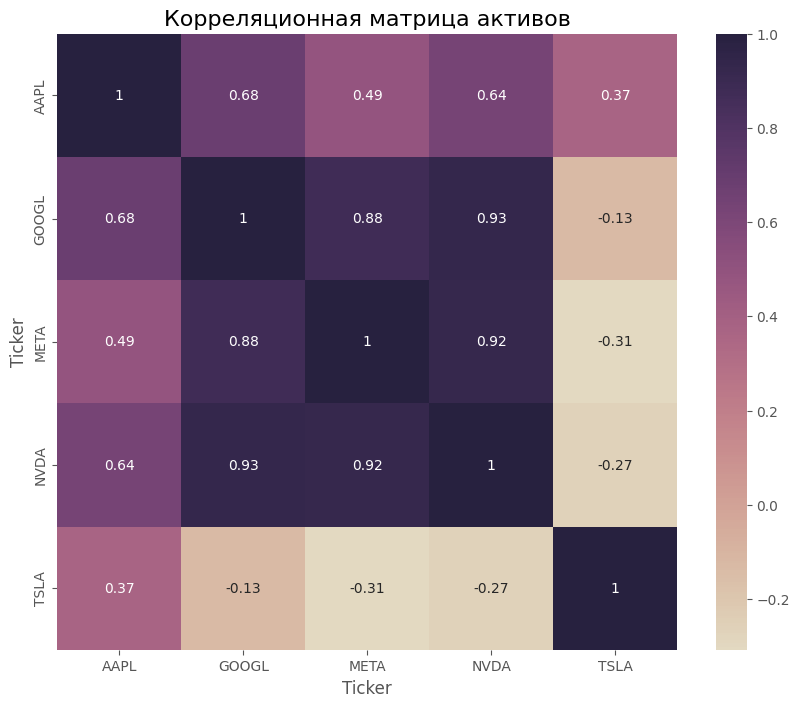

In [ ]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot = True, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

plt.title("Корреляционная матрица активов", fontsize=16)

plt.show()

**Пара с максимальным коэффициентом корреляции**

In [ ]:
corr_pairs = correlation_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)
sorted_pairs = sorted_pairs[sorted_pairs < 1]
max_corr_pair = sorted_pairs.idxmax()

print(f"Max correlation between {max_corr_pair}: {sorted_pairs.max():.2f}")

Max correlation between ('GOOGL', 'NVDA'): 0.93


### **Вывод закона, описывающего зависимость котировок актива GOOGL от котировок актива NVDA**

Сравнение пары с максимальной кореляцией

In [ ]:
active_a = max_corr_pair[0]
active_b = max_corr_pair[1]

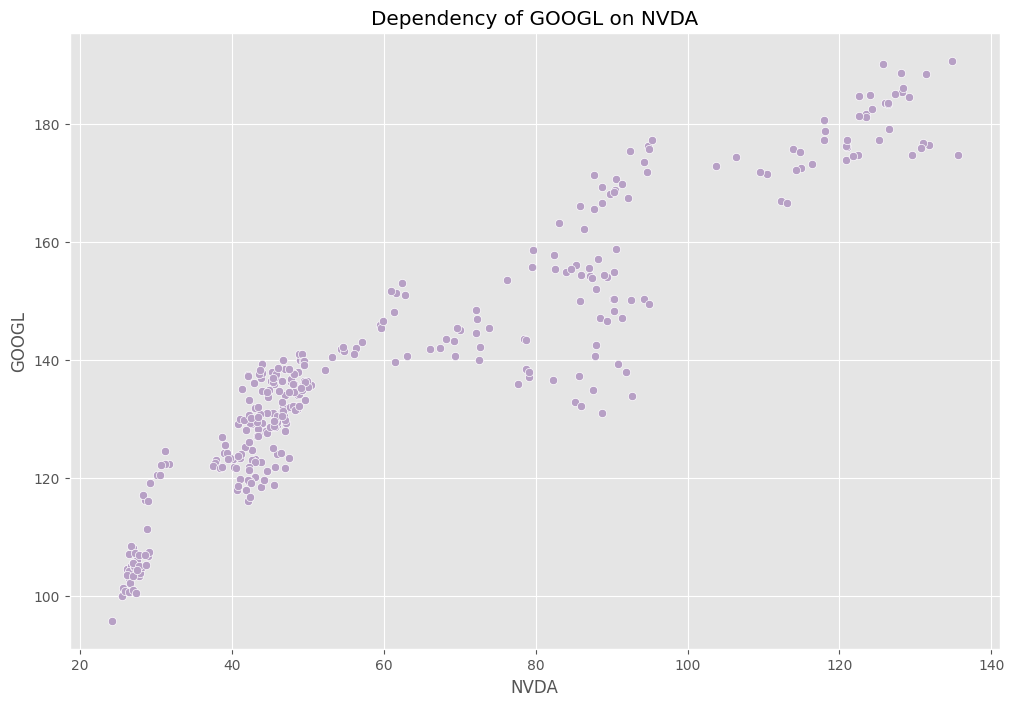

In [ ]:
plt.figure(figsize=(12, 8))
plt.title(f'Dependency of {active_a} on {active_b}')

sns.scatterplot(x=data[active_b], y=data[active_a], color="#B7A0C5")
plt.xlabel(active_b)
plt.ylabel(active_a)

plt.show()

### **Линейная регрессия**

In [ ]:
from sklearn.linear_model import LinearRegression

X = data[active_b].values.reshape(-1, 1)
Y = data[active_a].values

model = LinearRegression()
model.fit(X, Y)

k = model.coef_[0]
b = model.intercept_

print(f"Oscillatory dependence: {active_a} = {k:.2f} * {active_b} + {b:.2f}")

Oscillatory dependence: GOOGL = 0.68 * NVDA + 96.59


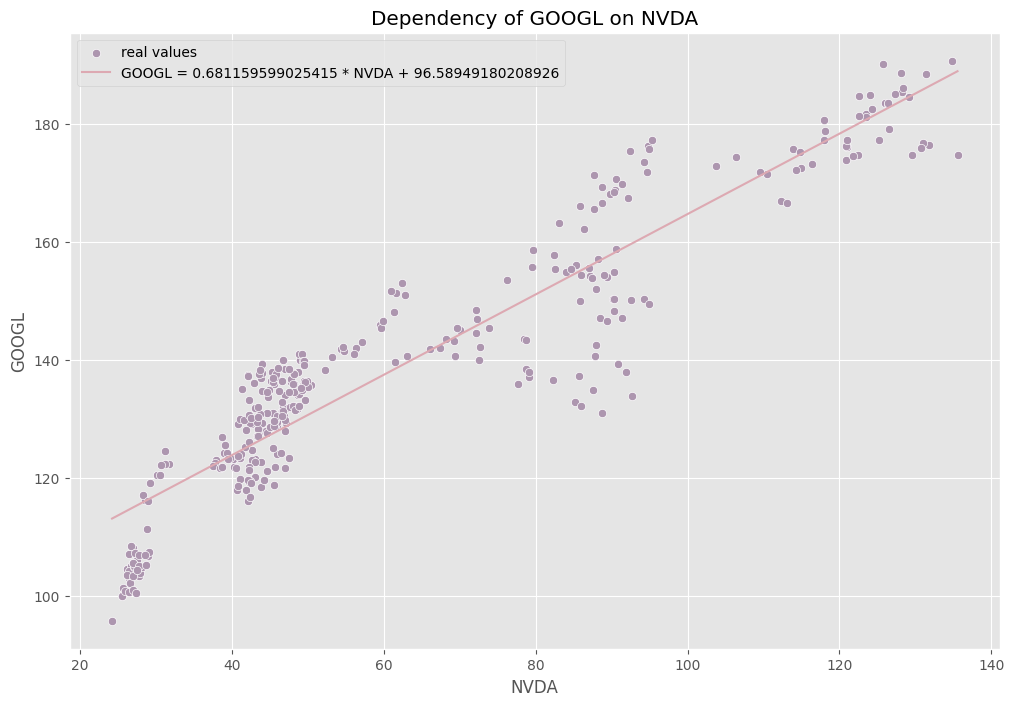

In [ ]:
plt.figure(figsize=(12, 8))
plt.title(f'Dependency of {active_a} on {active_b}')

sns.scatterplot(x=data[active_b], y=data[active_a], color='#ad96af', label="real values")

line_x = np.linspace(data[active_b].min(), data[active_b].max(), 100)
line_y = k * line_x + b
plt.plot(line_x, line_y, color='#dda9b2', label=f"{active_a} = {k} * {active_b} + {b}")

plt.xlabel(active_b)
plt.ylabel(active_a)

plt.legend()

plt.show()

In [ ]:
new_start_date = end_date
new_end_date = datetime.today()

new_data = yf.download(tickers, start=new_start_date.strftime('%Y-%m-%d'), end=new_end_date.strftime('%Y-%m-%d'))['Adj Close']

full_data = pd.concat([data, new_data])

new_X = new_data[active_b].values.reshape(-1, 1)
predicted_Y = model.predict(new_X)

[*********************100%***********************]  5 of 5 completed


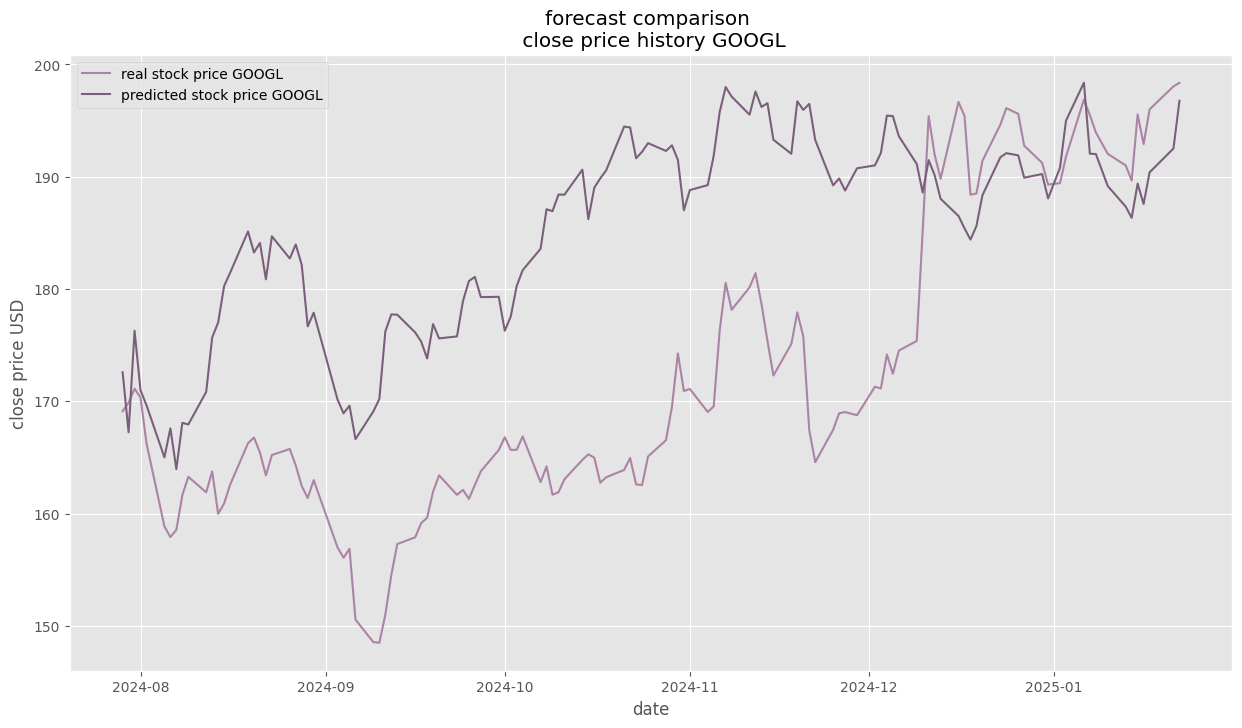

In [ ]:
plt.figure(figsize=(15, 8))
plt.title(f'forecast comparison \n close price history {active_a}')

plt.plot(new_data.index, new_data[active_a], color='#aa83a6', label=f'real stock price {active_a}')
plt.plot(new_data.index, predicted_Y, color='#7a5f7c', label=f'predicted stock price {active_a}')

plt.xlabel('date')
plt.ylabel('close price USD')
plt.legend()

plt.show()

In [ ]:
from prettytable import PrettyTable
import sklearn.metrics
import math

def report_performance(y: np.ndarray, predictions: np.ndarray, title):
    report_performance = PrettyTable()
    report_performance.title = title
    report_performance.field_names = ['MSE', 'MAE', 'RMSE', 'MAPE']

    mse = sklearn.metrics.mean_squared_error(y, predictions)
    mae = sklearn.metrics.mean_absolute_error(y, predictions)
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y, predictions))
    mape = sklearn.metrics.mean_absolute_percentage_error(y, predictions)

    report_performance.add_row([mse, mae, rmse, mape])

    print(report_performance)

In [ ]:
report_performance(new_data[active_a], predicted_Y, "report performance")

+---------------------------------------------------------------------------------+
|                                report performance                               |
+------------------+--------------------+-------------------+---------------------+
|       MSE        |        MAE         |        RMSE       |         MAPE        |
+------------------+--------------------+-------------------+---------------------+
| 286.818684591905 | 14.711675681710485 | 16.93572214556867 | 0.08827058637975649 |
+------------------+--------------------+-------------------+---------------------+


### **Автокорреляционный анализ котировок актива A**



In [ ]:
from matplotlib.collections import PolyCollection, LineCollection

def change_color(color, curr_ax):
    for item in curr_ax.collections:
        if type(item) == PolyCollection:
            item.set_facecolor(color)
        if type(item) == LineCollection:
            item.set_color(color)

    for item in curr_ax.lines:
        item.set_color(color)

In [ ]:
import matplotlib.pyplot as plt

def autocorrelation_analysis(series, N_values, max_lag_factor=10):
    avg_autocorr_dict = {}

    for N in N_values:
        lags = [lag * N for lag in range(1, max_lag_factor + 1)]
        autocorr_values = []

        for lag in lags:
            if lag < len(series):
                autocorr = series.autocorr(lag=lag)
                autocorr_values.append(autocorr)
            else:
                print(f"Lag {lag} exceeds the length of the series. Skipping.")
                autocorr_values.append(np.nan)

        autocorr_values_clean = [val for val in autocorr_values if not np.isnan(val)]

        # average autocorrelation for this N
        if autocorr_values_clean:
            avg_autocorr = np.mean(autocorr_values_clean)
            avg_autocorr_dict[N] = avg_autocorr
        else:
            avg_autocorr_dict[N] = np.nan

    plt.figure(figsize=(10, 6))
    N_values = list(avg_autocorr_dict.keys())
    avg_autocorr_values = list(avg_autocorr_dict.values())

    plt.plot(N_values, avg_autocorr_values, marker='o', linestyle='-', color='#7a5f7c')
    plt.title('Average Autocorrelation for Different N')
    plt.xlabel('N (Window Size)')
    plt.ylabel('Average Autocorrelation')
    plt.grid(True)
    plt.show()

    return avg_autocorr_dict


Lag 500 exceeds the length of the series. Skipping.


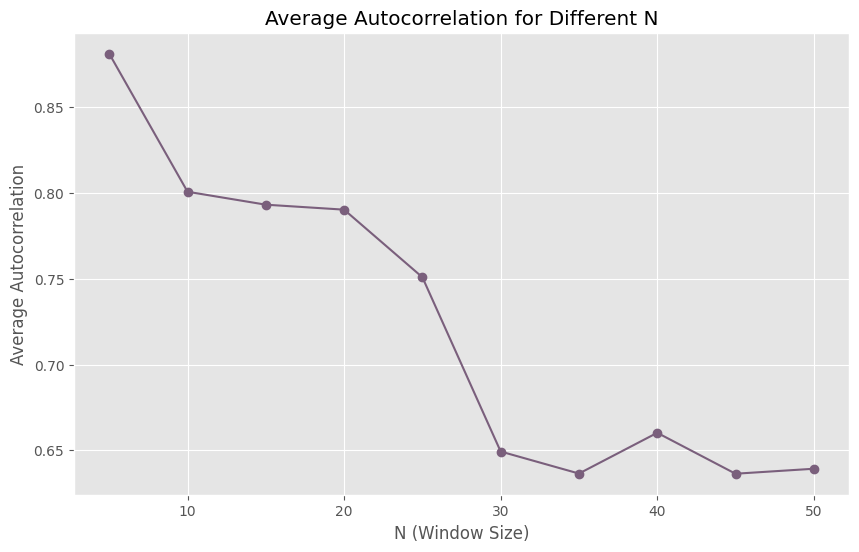

In [ ]:
N_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
active_a_full = full_data[active_a].dropna()
avg_autocorr_results = autocorrelation_analysis(active_a_full, N_values)

In [ ]:
table = PrettyTable()
table.field_names = ["N", "Average Autocorrelation"]

for N, avg_corr in avg_autocorr_results.items():
    if not np.isnan(avg_corr):
        table.add_row([N, f"{avg_corr:.2f}"])
    else:
        table.add_row([N, "NaN"])

print("Average autocorrelations for different N values:")
print(table)

Average autocorrelations for different N values:
+----+-------------------------+
| N  | Average Autocorrelation |
+----+-------------------------+
| 5  |           0.88          |
| 10 |           0.80          |
| 15 |           0.79          |
| 20 |           0.79          |
| 25 |           0.75          |
| 30 |           0.65          |
| 35 |           0.64          |
| 40 |           0.66          |
| 45 |           0.64          |
| 50 |           0.64          |
+----+-------------------------+


In [ ]:
valid_avg_autocorr = {k: v for k, v in avg_autocorr_results.items() if not np.isnan(v)}
if valid_avg_autocorr:
    optimal_N = max(valid_avg_autocorr, key=valid_avg_autocorr.get)
    print(f"Optimal period (N) with maximum average autocorrelation: {optimal_N}")
else:
    print("No valid average autocorrelations for determining the characteristic period.")

Optimal period (N) with maximum average autocorrelation: 5
